# COVID-19 Mental Health Mapping

### Install Packages

In [56]:
!pip install nltk
!pip install pandas_profiling
!pip install wordcloud
!pip install opencv-python
!pip install ipython-autotime

time: 10.7 s (started: 2021-11-27 17:57:16 +00:00)


### Import Libraries

In [130]:
#Data Analysis
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
%load_ext autotime
import scipy
import seaborn as sns
import pandas_profiling
from collections import Counter
import cv2
import datetime
format="%Y-%m-%d"

#Feature Engineering & Models
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

#NLP
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))
stopwords.update(['I', "I'm",'im', 'st', 'r', 'guys','hey','hello', 'hi'])

import re
from wordcloud import WordCloud, ImageColorGenerator
nltk.download('punkt')

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

time: 152 ms (started: 2021-11-27 21:00:00 +00:00)


## Reddit Analysis 

Reddit data is used for directional analysis into the types of mental health issues people are most likely to face during COVID-19. Reddit focuses on anonymous user conversations, and as a result is useful for capturing genuine discussions around mental health which may be missing in Twitter data due to the non-anonymized nature of the platform. 

Reddit may also be used as a training source in order to build a supervised learning model that classifies posts into mental health indications from Twitter.
Posts are sourced from subreddits dedicated to conversations around mental health issues (r/COVID19_support, r/depression, r/anxiety, r/HealthAnxiety, r/bipolar, r/schizophrenia). 

We can use this 'labelled' data to train a classification model, which will be used to organize social media posts into various mental health conditions.

In [58]:
#Load corpus of Reddit posts. 
#Dates: Jan 1 2020 - Sept 30 2021
reddit_df = pd.read_csv('reddit_corpus.csv')
reddit_df = pd.DataFrame(reddit_df)
reddit_df = reddit_df[reddit_df['Subreddit'].notna()]


#Convert Date values to datetime64 

reddit_df['Date'] = pd.to_datetime(reddit_df['Date'], format = "%m/%d/%Y")

#Analyze only posts from Jan 2020 - Sept 2021 (drop Oct 2021 posts)
reddit_df = reddit_df[(reddit_df['Date'] < '10/1/2021')]


#Reddit posts are extracted with the post Title and the "Snippet", which may be a further explanation of the post or a response by another user to the post. To avoid artifically inflating terms, we limit each 
# post to appearing only once in the dataset by removing duplicate "Title" & "Snippet" values.

reddit_df = reddit_df.drop_duplicates(subset=['Title'])
reddit_df = reddit_df.drop_duplicates(subset=['Snippet'])

#In order to capture the maximum amount of contextual conversation possible, we concatenate both columns to produce one column with all words in both the post title and reply/snippet.
content = []
for i in reddit_df.index:
    content.append(str(reddit_df['Title'][i]) + " " + str(reddit_df['Snippet'][i]))

reddit_df['content'] = content

reddit_df = reddit_df.drop_duplicates(subset=['content'])

reddit_df


,Query Id,Query Name,Subreddit,Date,Title,Snippet,content
0,2.000748e+09,Mental Health,r/Anxiety,2020-05-08,Always need a deep breathe!,...Later on I heard another woman describing a...,Always need a deep breathe! ...Later on I hear...
1,2.000748e+09,Mental Health,r/Anxiety,2020-04-21,Let's post good news on the coronavirus here.,Agreed! I do like a nice latte once in a while...,Let's post good news on the coronavirus here. ...
2,2.000748e+09,Mental Health,r/Anxiety,2020-08-20,Does anyone else experience back to work anxiety,Only when I hated my job (when I was in retail...,Does anyone else experience back to work anxie...
3,2.000748e+09,Mental Health,r/Anxiety,2020-05-26,I cant walk through a town or even a village o...,Does your mom keep you updated on the news on ...,I cant walk through a town or even a village o...
4,2.000748e+09,Mental Health,r/Anxiety,2021-08-23,Just took my medication for the first time,I remember the lead up to beginning meds (I’m ...,Just took my medication for the first time I r...
...,...,...,...,...,...,...,...
18400,2.000748e+09,Mental Health,r/schizophrenia,2021-09-29,Delusions have been getting worse,I keep on thinking I have a serious sickness b...,Delusions have been getting worse I keep on th...
18401,2.000748e+09,Mental Health,r/schizophrenia,2021-08-16,First day on college campus. Pretty nervous bu...,"I gotchu buddy, I've figured schizophrenia out...",First day on college campus. Pretty nervous bu...
18403,2.000748e+09,Mental Health,r/schizophrenia,2020-02-04,What is your experience with having psychosis ...,I am diagnosed with schizoaffective disorder (...,What is your experience with having psychosis ...
18404,2.000748e+09,Mental Health,r/schizophrenia,2021-01-15,How should closed ones react?,Like I said I’m prospering with no medication ...,How should closed ones react? Like I said I’m ...


time: 692 ms (started: 2021-11-27 17:57:27 +00:00)


In [59]:
#Total subreddit post volumes
Counter(reddit_df['Subreddit'])

Counter({'r/Anxiety': 4324,
         'r/bipolar': 3357,
         'r/Depression': 4370,
         'r/schizophrenia': 2877})

time: 4.81 ms (started: 2021-11-27 17:57:28 +00:00)


## Exploratory Data Analysis

Distribution of posts by Mental Health category

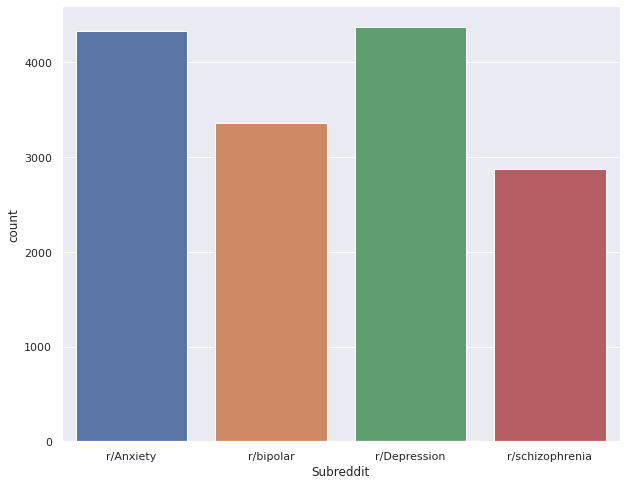

time: 233 ms (started: 2021-11-27 17:57:28 +00:00)


In [60]:
sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
ax = sns.countplot(x='Subreddit', data=reddit_df)
plt.savefig('counts.png')

Distribution of post lengths within each mental health category

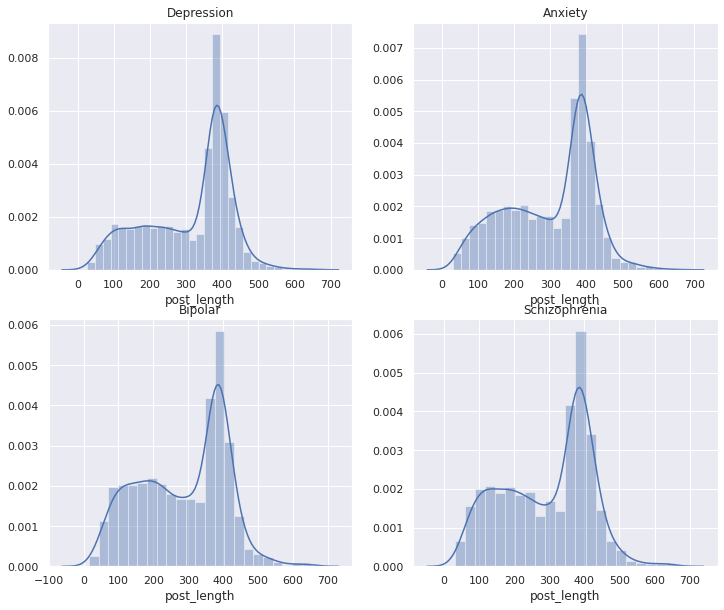

time: 1.65 s (started: 2021-11-27 17:57:28 +00:00)


In [61]:
reddit_df['post_length'] = reddit_df['content'].str.len()


fig = plt.figure(figsize=(12,10))

rows=2
columns = 2

fig.add_subplot(rows, columns, 1)
sns.distplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/Depression'])
#plt.axis('off')
plt.title('Depression')

fig.add_subplot(rows, columns, 2)
sns.distplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/Anxiety'])
#plt.axis('off')
plt.title('Anxiety')

fig.add_subplot(rows, columns, 3)
sns.distplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/bipolar'])
#plt.axis('off')
plt.title('Bipolar')

fig.add_subplot(rows, columns, 4)
sns.distplot(reddit_df['post_length'][reddit_df['Subreddit'] == 'r/schizophrenia'])
#plt.axis('off')
plt.title('Schizophrenia')



plt.savefig('post_length.png')
reddit_df['post_length'].describe()

plt.show()

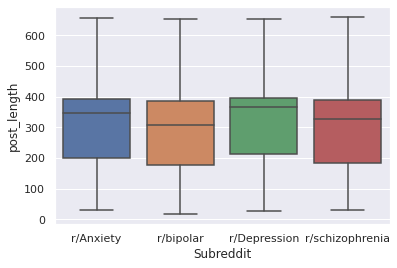

time: 246 ms (started: 2021-11-27 17:57:29 +00:00)


In [62]:
sns.boxplot(data=reddit_df, x='Subreddit', y='post_length')
plt.savefig('post_length_boxplot.png')
plt.show()

In [63]:
#profile = pandas_profiling.ProfileReport(reddit_df)
#profile.to_file(output_file = 'reddit_df.html')

time: 315 µs (started: 2021-11-27 17:57:30 +00:00)


## Text Preprocessing

The first step in creating a text classification model is to run the necessary preprocessing on all posts

In [64]:
#Data Cleaning - Content Field
#Reddit posts are storied as a list of string values. To process each string value in the list, iterate the function over each string item in the list. Then return formatted lists
# to string format
lowercase_posts = []
for i in reddit_df.index:
    lowercase_posts.append(reddit_df['content'][i].lower())

reddit_df['content'] = lowercase_posts

#Remove punctuation from posts
strip_punctuation = []
for i in reddit_df.index:
    strip_punctuation.append(reddit_df['content'][i].translate(str.maketrans('','',string.punctuation)))

reddit_df['content'] = strip_punctuation

#Tokenize each string input to generate list of lists containing string values
tokenized_posts = []
for i in reddit_df.index:
    tokenized_posts.append(word_tokenize(reddit_df['content'][i]))

reddit_df['content'] = tokenized_posts

#Remove stopwords

filtered_posts = []
for i in reddit_df.index:
    filtered_posts.append([w for w in reddit_df['content'][i] if w not in stopwords])
    
reddit_df['content'] = filtered_posts

#Convert processed text from list to string

new_strings = []
for i in reddit_df.index:
    new_strings.append(' '.join(reddit_df['content'][i]))

reddit_df['content'] = new_strings

reddit_df

,Query Id,Query Name,Subreddit,Date,Title,Snippet,content,post_length
0,2.000748e+09,Mental Health,r/Anxiety,2020-05-08,Always need a deep breathe!,...Later on I heard another woman describing a...,always need deep breathe later heard another w...,381
1,2.000748e+09,Mental Health,r/Anxiety,2020-04-21,Let's post good news on the coronavirus here.,Agreed! I do like a nice latte once in a while...,lets post good news coronavirus agreed like ni...,204
2,2.000748e+09,Mental Health,r/Anxiety,2020-08-20,Does anyone else experience back to work anxiety,Only when I hated my job (when I was in retail...,anyone else experience back work anxiety hated...,113
3,2.000748e+09,Mental Health,r/Anxiety,2020-05-26,I cant walk through a town or even a village o...,Does your mom keep you updated on the news on ...,cant walk town even village without mum 19 yea...,542
4,2.000748e+09,Mental Health,r/Anxiety,2021-08-23,Just took my medication for the first time,I remember the lead up to beginning meds (I’m ...,took medication first time remember lead begin...,394
...,...,...,...,...,...,...,...,...
18400,2.000748e+09,Mental Health,r/schizophrenia,2021-09-29,Delusions have been getting worse,I keep on thinking I have a serious sickness b...,delusions getting worse keep thinking serious ...,385
18401,2.000748e+09,Mental Health,r/schizophrenia,2021-08-16,First day on college campus. Pretty nervous bu...,"I gotchu buddy, I've figured schizophrenia out...",first day college campus pretty nervous making...,193
18403,2.000748e+09,Mental Health,r/schizophrenia,2020-02-04,What is your experience with having psychosis ...,I am diagnosed with schizoaffective disorder (...,experience psychosis long many times without p...,517
18404,2.000748e+09,Mental Health,r/schizophrenia,2021-01-15,How should closed ones react?,Like I said I’m prospering with no medication ...,closed ones react like said ’ prospering medic...,207


time: 6.79 s (started: 2021-11-27 17:57:30 +00:00)


In [65]:
#Data Cleaning - Title Field
#Reddit posts are storied as a list of string values. To process each string value in the list, iterate the function over each string item in the list. Then return formatted lists
# to string format

lowercase_posts = []
for i in reddit_df.index:
    lowercase_posts.append(reddit_df['Title'][i].lower())

reddit_df['Title'] = lowercase_posts

#Remove punctuation from posts
strip_punctuation = []
for i in reddit_df.index:
    strip_punctuation.append(reddit_df['Title'][i].translate(str.maketrans('','',string.punctuation)))

reddit_df['Title'] = strip_punctuation

#Tokenize each string input to generate list of lists containing string values
tokenized_posts = []
for i in reddit_df.index:
    tokenized_posts.append(word_tokenize(reddit_df['Title'][i]))

reddit_df['Title'] = tokenized_posts

#Remove stopwords

filtered_posts = []
for i in reddit_df.index:
    filtered_posts.append([w for w in reddit_df['Title'][i] if w not in stopwords])
    
reddit_df['Title'] = filtered_posts

#Convert processed text from list to string

new_strings = []
for i in reddit_df.index:
    new_strings.append(' '.join(reddit_df['Title'][i]))

reddit_df['Title'] = new_strings

reddit_df

,Query Id,Query Name,Subreddit,Date,Title,Snippet,content,post_length
0,2.000748e+09,Mental Health,r/Anxiety,2020-05-08,always need deep breathe,...Later on I heard another woman describing a...,always need deep breathe later heard another w...,381
1,2.000748e+09,Mental Health,r/Anxiety,2020-04-21,lets post good news coronavirus,Agreed! I do like a nice latte once in a while...,lets post good news coronavirus agreed like ni...,204
2,2.000748e+09,Mental Health,r/Anxiety,2020-08-20,anyone else experience back work anxiety,Only when I hated my job (when I was in retail...,anyone else experience back work anxiety hated...,113
3,2.000748e+09,Mental Health,r/Anxiety,2020-05-26,cant walk town even village without mum 19 yea...,Does your mom keep you updated on the news on ...,cant walk town even village without mum 19 yea...,542
4,2.000748e+09,Mental Health,r/Anxiety,2021-08-23,took medication first time,I remember the lead up to beginning meds (I’m ...,took medication first time remember lead begin...,394
...,...,...,...,...,...,...,...,...
18400,2.000748e+09,Mental Health,r/schizophrenia,2021-09-29,delusions getting worse,I keep on thinking I have a serious sickness b...,delusions getting worse keep thinking serious ...,385
18401,2.000748e+09,Mental Health,r/schizophrenia,2021-08-16,first day college campus pretty nervous making...,"I gotchu buddy, I've figured schizophrenia out...",first day college campus pretty nervous making...,193
18403,2.000748e+09,Mental Health,r/schizophrenia,2020-02-04,experience psychosis long many times without p...,I am diagnosed with schizoaffective disorder (...,experience psychosis long many times without p...,517
18404,2.000748e+09,Mental Health,r/schizophrenia,2021-01-15,closed ones react,Like I said I’m prospering with no medication ...,closed ones react like said ’ prospering medic...,207


time: 4.04 s (started: 2021-11-27 17:57:36 +00:00)


In [66]:
#After initial run through, it was noticed that many similar terms occur more than once in listing of highly correlated terms within categories. To offset this, a lemmatization step is added. This step reduced words
#to their lemma, removing inflections and reducing redundant words. The analysis is run again to see if there is an improvement in model accuracy.
wn = WordNetLemmatizer()
lemmatized_posts = []

for i in reddit_df.index:
    lemmatized_content = []
    post = reddit_df['content'][i]
    post_words = post.split(" ")
    for word in post_words:
        lemmatized_content.append(wn.lemmatize(word, pos='v'))
    lemmatized_post = " ".join(lemmatized_content)
    lemmatized_posts.append(lemmatized_post)

reddit_df['content'] = lemmatized_posts


time: 2.25 s (started: 2021-11-27 17:57:41 +00:00)


In [67]:
reddit_df['content'][1]

'let post good news coronavirus agree like nice latte really good day upset stomachand anxiety cycle begin lol 🙄🙄'

time: 2.8 ms (started: 2021-11-27 17:57:43 +00:00)


## Topic Analysis within Mental Health indications

As an intitial step, we can get a sense of the most frequently occuring terms & conversation topics within each Subreddit using a WordCloud analysis

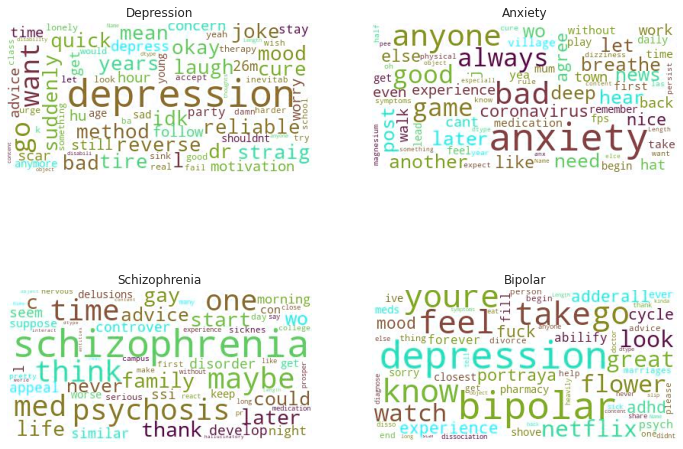

time: 1.36 s (started: 2021-11-27 17:57:43 +00:00)


In [68]:
#Generate wordclouds for each subreddit and save the output to an image file
overall_wc = WordCloud(stopwords = stopwords, max_font_size=50, max_words=100, background_color="white").generate(str(reddit_df['content']))
overall_wc.to_file('overall.jpg')

depression_wc = WordCloud(stopwords = stopwords, max_font_size=50, max_words=100, background_color="white").generate(str(reddit_df['content'][reddit_df.Subreddit.eq('r/Depression')]))
depression_wc.to_file('depression.jpg')

anxiety_wc = WordCloud(stopwords = stopwords, max_font_size=50, max_words=100, background_color="white").generate(str(reddit_df['content'][reddit_df.Subreddit.eq('r/Anxiety')]))
anxiety_wc.to_file('anxiety.jpg')


schizophrenia_wc = WordCloud(stopwords = stopwords, max_font_size=50, max_words=100, background_color="white").generate(str(reddit_df['content'][reddit_df.Subreddit.eq('r/schizophrenia')]))
schizophrenia_wc.to_file('schizophrenia.jpg')

bipolar_wc = WordCloud(stopwords = stopwords, max_font_size=50, max_words=100, background_color="white").generate(str(reddit_df['content'][reddit_df.Subreddit.eq('r/bipolar')]))
bipolar_wc.to_file('bipolar.jpg')


#Set up figure
fig = plt.figure(figsize=(12,9))

rows=2
columns = 2

#Read images and add to figure
fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.imread('depression.jpg'))
plt.axis('off')
plt.title('Depression')

fig.add_subplot(rows, columns, 2)
plt.imshow(cv2.imread('anxiety.jpg'))
plt.axis('off')
plt.title('Anxiety')


fig.add_subplot(rows, columns, 3)
plt.imshow(cv2.imread('schizophrenia.jpg'))
plt.axis('off')
plt.title('Schizophrenia')

fig.add_subplot(rows, columns, 4)
plt.imshow(cv2.imread('bipolar.jpg'))
plt.axis('off')
plt.title('Bipolar')

plt.show()

## Predictive Model for Text Classification

Numeric values are assigned to mental health categories by creating a dictionary of key value pairs in order to format the data for input into predictive models.

In [69]:
topic_codes = {'r/Depression' : 0,
                      'r/Anxiety' : 1,
                      'r/bipolar' : 2,
                      'r/schizophrenia' : 3}

reddit_df['topic_code'] = reddit_df['Subreddit']
reddit_df = reddit_df.replace({'topic_code':topic_codes})

reddit_df.head()

,Query Id,Query Name,Subreddit,Date,Title,Snippet,content,post_length,topic_code
0,2.000748e+09,Mental Health,r/Anxiety,2020-05-08,always need deep breathe,...Later on I heard another woman describing a...,always need deep breathe later hear another wo...,381,1
1,2.000748e+09,Mental Health,r/Anxiety,2020-04-21,lets post good news coronavirus,Agreed! I do like a nice latte once in a while...,let post good news coronavirus agree like nice...,204,1
2,2.000748e+09,Mental Health,r/Anxiety,2020-08-20,anyone else experience back work anxiety,Only when I hated my job (when I was in retail...,anyone else experience back work anxiety hat j...,113,1
3,2.000748e+09,Mental Health,r/Anxiety,2020-05-26,cant walk town even village without mum 19 yea...,Does your mom keep you updated on the news on ...,cant walk town even village without mum 19 yea...,542,1
4,2.000748e+09,Mental Health,r/Anxiety,2021-08-23,took medication first time,I remember the lead up to beginning meds (I’m ...,take medication first time remember lead begin...,394,1


time: 31.3 ms (started: 2021-11-27 17:57:44 +00:00)


## TF-IDF

TF-IDF Vectors will be used as features to train our predictive model. TF-IDF scores represent the relative importance of terms in both documents and the entire corpus. In this case, each reddit post within subreddit represents a "document" and the entire set of reddit posts within a subreddit represents our corpus.

In order to convert text into a machine-learning readable format, the text must have a numeric representation. TF-IDF achieves this by assigning a score to each term in our posts that capture the relative importance of the term in the document. 

***Definitions:***

**Term Frequency (TF):**

A normalized measure of how frequently a term appears in a document. In this measure, it is assummed that words which appear more frequently are of greater importance

tf(w) = count(w)/total words in document

**Inverse Document Frequency (IDF):**

IDF helps to reduce the importance of terms that have a high term frequency, but are very common across all documents and are therefore have less impact on the meaning of a post.A measure of how "important" a term is by assessing how common it is across all documents.

idf(w) = log(total number of documents/number of documents containing w)


**TF-IDF:** 

The product of term frequency and inverse document frequency. This gives us a normalized score for how important a word is within a document.

tf-idf(w) = tf(w) * idf(w)



**Here, the parameters are set for TF-IDF vectorization.**

Parameters:

ngram_range: The upper and lower boundary of the range of n-values for different n-grams to be extracted. n-grams are continuous sequences of characters that appear sequentally. 
Setting ngram_range to (1,1) instructs the algorithm to extract only single words (unigrams). This can also be set to both unigrams and bigrams (1,2), or only bigrams (2,2).

min_df = This instructs the algorithm to ignore terms which have a document frequency lower than the given threshold. Document Frequency is the number of documents (posts) containing
a particular term.

max_df = This instructs the algorithm to ignore terms which have a document frequency higher than the given threshold.

max_features = The maximum amount of features to accept per document. We will set this to 500 (well above average post length) to capture all features.

stop_words = Words to exclude from feature list. We will use the stopwords variable which has already been prepared.

In [70]:
#Check which words occur most frequently in the training dataset:
wordcounts = Counter(' '.join(x_train).split()).most_common()
wordcounts[:25]

[('’', 10429),
 ('anxiety', 5747),
 ('get', 4719),
 ('feel', 4586),
 ('like', 4143),
 ('depression', 3392),
 ('go', 3025),
 ('think', 2826),
 ('help', 2557),
 ('know', 2543),
 ('make', 2348),
 ('people', 2338),
 ('bipolar', 2203),
 ('time', 2109),
 ('really', 2010),
 ('take', 2009),
 ('schizophrenia', 1989),
 ('dont', 1834),
 ('want', 1777),
 ('depress', 1729),
 ('try', 1710),
 ('work', 1674),
 ('life', 1633),
 ('one', 1418),
 ('even', 1391)]

time: 491 ms (started: 2021-11-27 17:57:44 +00:00)


In [71]:
#View words used as features in TFIDF
features_example = tfidf.get_feature_names()
features_example[:25]

['10',
 'able',
 'absolutely',
 'accept',
 'act',
 'actually',
 'adhd',
 'advice',
 'affect',
 'afraid',
 'age',
 'ago',
 'almost',
 'alone',
 'already',
 'also',
 'always',
 'another',
 'answer',
 'antidepressants',
 'anxiety',
 'anxiety attack',
 'anxiety depression',
 'anxiety get',
 'anxious']

time: 7.39 ms (started: 2021-11-27 17:57:45 +00:00)


Each document is now transformed into a TF-IDF vector for our training and test model. Each vector represents a document, with the numbers corresponding to the TF-IDF score for each word in the document. Fitting is performed only on the training data, as testing data should be used only to evaluate the model (model should not be fit to testing data).

In [72]:
#Example: TF-IDF scores for one post in training set
feature_scores = dict(zip(tfidf.get_feature_names(), features_train[1])) #Can use this function to view the TF-IDF scores of any given post for x_train by changing features_train index
example = sorted(feature_scores.items(), key = lambda x: x[1], reverse=True)
example[:25]


[('go', 0.3348878836944852),
 ('leave', 0.2829597428046972),
 ('felt', 0.281115491600038),
 ('sit', 0.26584728268085817),
 ('already', 0.2280742158193712),
 ('hours', 0.21825909769537855),
 ('make', 0.21532719719399665),
 ('everyday', 0.21502268315949025),
 ('lose', 0.20218031152478957),
 ('feel like', 0.2018953728550215),
 ('right', 0.2005475016106379),
 ('well', 0.19320890084683645),
 ('days', 0.19055430725084813),
 ('big', 0.18713515512629247),
 ('need help', 0.17870193525834147),
 ('would', 0.17492640670963822),
 ('open', 0.16831727913383787),
 ('literally', 0.16353188806517627),
 ('try', 0.16037060996714844),
 ('depress', 0.15918574891063375),
 ('really', 0.15244329612812246),
 ('time', 0.15048430723966685),
 ('mania', 0.14408091281683633),
 ('10', 0.0),
 ('able', 0.0)]

time: 9.2 ms (started: 2021-11-27 17:57:45 +00:00)


In [73]:
#reddit_df.to_csv('reddit_df.csv')

time: 1.1 ms (started: 2021-11-27 17:57:45 +00:00)


In order to understand how closely correlated a feature is to a mental health indication, we can use a Chi squared test. This function will compute the chi-squared test statistics between each feature (term) and class (mental health indication). Because chi2 tests measure the dependence between variables, we are able to select only features which are most likely to be highly dependent on class, and are therefore more relevant for classification. Using this information, we can return the unigrams and bigrams that are most closely associated with each mental health topic. In this case we see that there is quite a lot of crossover among the most highly correlated unigrams in each category, which may impact the models performance.

In [74]:
for Subreddit, topic_code in sorted(topic_codes.items()):
    features_chi2 = chi2(features_train, labels_train == topic_code)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [w for w in feature_names if len(w.split(' '))==1]
    bigrams = [w for w in feature_names if len(w.split(' '))==2]
    print("# '{}':".format(Subreddit))
    print("  . Top correlated unigrams:\n    . {}".format('\n    . '.join(unigrams[-10:])))
    print("  . Top correlated bigrams:\n    . {}".format('\n    . '.join(bigrams[-3:])))

# 'r/Anxiety':
  . Top correlated unigrams:
    . close
    . anxious
    . helpful
    . depress
    . parent
    . depression
    . anymore
    . paranoid
    . schizophrenia
    . away
  . Top correlated bigrams:
    . anxiety depression
    . bipolar disorder
    . anxiety attack
# 'r/Depression':
  . Top correlated unigrams:
    . want
    . havent
    . literally
    . last
    . symptoms
    . suicide
    . suicidal
    . schizophrenia
    . depress
    . depression
  . Top correlated bigrams:
    . suicidal thoughts
    . anxiety attack
    . bipolar disorder
# 'r/bipolar':
  . Top correlated unigrams:
    . depressive
    . disorder
    . especially
    . move
    . schizophrenia
    . ill
    . episodes
    . bite
    . may
    . maybe
  . Top correlated bigrams:
    . anxiety attack
    . diagnose bipolar
    . bipolar disorder
# 'r/schizophrenia':
  . Top correlated unigrams:
    . depress
    . depression
    . symptoms
    . voice
    . ptsd
    . delusions
    . happy
  

## Model Evaluation

In [75]:
ngram_range = (1,2)
min_df = 0
max_df = 1.0
max_features = 500  
stop_words = stopwords

time: 1.22 ms (started: 2021-11-27 17:57:45 +00:00)


In [115]:
#Prepare training and testing data for confusion matrix & quick testing

x_train, x_test, y_train, y_test = train_test_split(reddit_df['content'], reddit_df['topic_code'], test_size = 0.20, random_state=9)

tfidf = TfidfVectorizer(encoding = 'utf-8', 
                       ngram_range = ngram_range,
                       min_df = min_df,
                       max_df = max_df,
                       lowercase=False, 
                       max_features = max_features,
                       stop_words = None, 
                       norm = 'l2', 
                       sublinear_tf = True)

features_train = tfidf.fit_transform(x_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(x_test).toarray()
labels_test = y_test
print(features_test.shape)


(11942, 500)
(2986, 500)
time: 1.83 s (started: 2021-11-27 20:44:11 +00:00)


In [77]:
#Here data is prepared for use with cross_val_scores, using KFold cross validation
tfidf = TfidfVectorizer(encoding = 'utf-8', 
                       ngram_range = ngram_range,
                       min_df = min_df,
                       max_df = max_df,
                       lowercase=False, 
                       max_features = max_features,
                       stop_words = None, 
                       norm = 'l2', 
                       sublinear_tf = True)

x = tfidf.fit_transform(reddit_df['content']).toarray()
y = reddit_df['topic_code']
print(x.shape)

(14928, 500)
time: 2.12 s (started: 2021-11-27 17:57:47 +00:00)


### Naive Bayes

In [78]:
#Get current parameters
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
print(mnb.get_params())

#For Naive Bayes, the parameters will be left unchanged

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
time: 978 µs (started: 2021-11-27 17:57:49 +00:00)


In [131]:
#Using KFold cross validation. Splitting into train and test data is taken care of for each iteration, so declaring x_train, x_test etc. is not necessary
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

model_evaluation_kfold_mnb = {}
accuracy_scores = cross_val_score(mnb, x, y, cv=cv, scoring = 'accuracy')
model_evaluation_kfold_mnb.update({'Accuracy': accuracy_scores.mean()})

precision_scores = cross_val_score(mnb, x, y, cv=cv, scoring = 'precision_weighted') 
model_evaluation_kfold_mnb.update({'Precision': precision_scores.mean()})

recall_scores = cross_val_score(mnb, x, y, cv=cv, scoring = 'recall_weighted') 
model_evaluation_kfold_mnb.update({'Recall': recall_scores.mean()})

f1_scores = cross_val_score(mnb, x, y, cv=cv, scoring = 'f1_weighted') 
model_evaluation_kfold_mnb.update({'F1': f1_scores.mean()})

model_evaluation_kfold_mnb

{'Accuracy': 0.7763898191560616,
 'Precision': 0.7889619323029871,
 'Recall': 0.7763898191560616,
 'F1': 0.7769124130460903}

time: 4.11 s (started: 2021-11-27 21:00:11 +00:00)


Multiple Naive Bayes Classification Report
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       928
           1       0.77      0.84      0.80       815
           2       0.81      0.68      0.74       661
           3       0.89      0.71      0.79       582

    accuracy                           0.78      2986
   macro avg       0.80      0.77      0.78      2986
weighted avg       0.79      0.78      0.78      2986



{'Naive Bayes': [0.7940043543795009, 0.7779638312123242]}

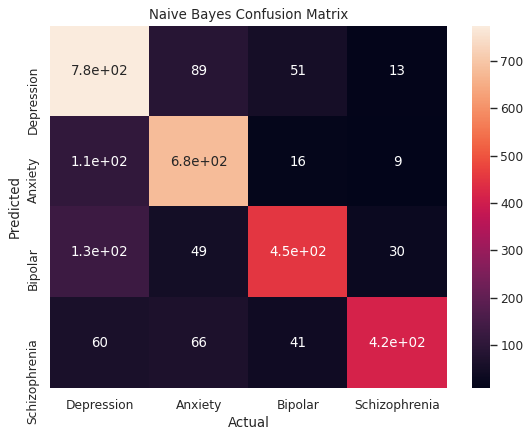

time: 502 ms (started: 2021-11-27 20:47:57 +00:00)


In [124]:
#To generate Confusion Matrix, use train test split as a sample and perform 
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

#Fit model to training data
mnb_model = mnb.fit(features_train, labels_train)

#Predict outputs from the model using our test data
mnb_predictions = mnb_model.predict(features_test)

#Print model evaluation report
print ("Multiple Naive Bayes Classification Report")
print(classification_report(labels_test, mnb_predictions))

#Confusion Matrix

figure(figsize=(8, 6), dpi=80)
cfmatrix = confusion_matrix(labels_test, mnb_predictions)
sns.heatmap(cfmatrix, annot=True, xticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'], yticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'])
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Naive Bayes Confusion Matrix')

#Create dictionary to store values for model comparison. Include model accuracy on both Training and Testing data to ensure model isn't overfit

model_evaluation = {'Naive Bayes' : [accuracy_score(labels_train, mnb.predict(features_train)),accuracy_score(labels_test, mnb_predictions)]}

model_evaluation

In [ ]:
#View the most important features for classification using the Naive Bayes model


## Logistic Regression

In [84]:
#Get current parameters
from sklearn.linear_model import LogisticRegression
lgreg = LogisticRegression()
print(lgreg.get_params())
#In order to use logistic regression for multiclass (non-binary) classification, we have to set the multi_class parameter to 'multinomial'

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
time: 1.26 ms (started: 2021-11-27 18:30:07 +00:00)


In [85]:
lgreg = LogisticRegression(multi_class='multinomial', max_iter = 300) #Set parameters

time: 663 µs (started: 2021-11-27 18:30:09 +00:00)


In [132]:
#Using KFold cross validation. Splitting into train and test data is taken care of for each iteration, so declaring x_train, x_test etc. is not necessary
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
model_evaluation_kfold_lgreg = {}

accuracy_scores = cross_val_score(lgreg, x, y, cv=cv, scoring = 'accuracy')
model_evaluation_kfold_lgreg.update({'Accuracy': accuracy_scores.mean()})

precision_scores = cross_val_score(lgreg, x, y, cv=cv, scoring = 'precision_weighted') 
model_evaluation_kfold_lgreg.update({'Precision': precision_scores.mean()})

recall_scores = cross_val_score(lgreg, x, y, cv=cv, scoring = 'recall_weighted') 
model_evaluation_kfold_lgreg.update({'Recall': recall_scores.mean()})

f1_scores = cross_val_score(lgreg, x, y, cv=cv, scoring = 'f1_weighted') 
model_evaluation_kfold_lgreg.update({'F1': f1_scores.mean()})

model_evaluation_kfold_lgreg

{'Accuracy': 0.8433690555927662,
 'Precision': 0.8480897120986766,
 'Recall': 0.8433690555927662,
 'F1': 0.8426400926658735}

time: 4min 25s (started: 2021-11-27 21:02:43 +00:00)


Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       928
           1       0.84      0.93      0.88       815
           2       0.84      0.76      0.80       661
           3       0.93      0.79      0.85       582

    accuracy                           0.85      2986
   macro avg       0.86      0.84      0.85      2986
weighted avg       0.85      0.85      0.85      2986



{'Naive Bayes': [0.792162116898342, 0.7756195579370395],
 'Logistic Regression': [0.8656841400100486, 0.8509711989283322],
 'KNN': [0.7621838887958466, 0.7397856664434025]}

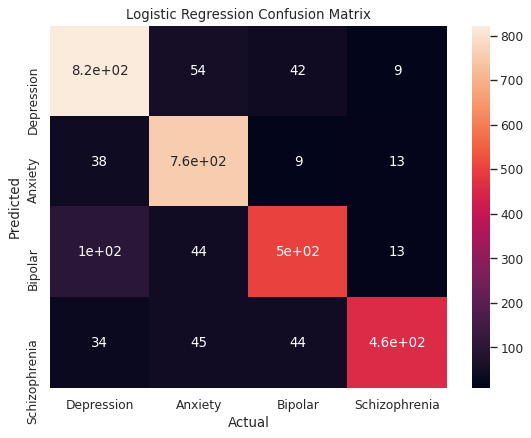

time: 6.81 s (started: 2021-11-27 20:44:23 +00:00)


In [116]:
lgreg_model = lgreg.fit(features_train, labels_train)
lgreg_predictions = lgreg_model.predict(features_test)

print ("Logistic Regression Classification Report")
print(classification_report(labels_test, lgreg_predictions))

#Confusion Matrix
figure(figsize=(8, 6), dpi=80)
cfmatrix = confusion_matrix(labels_test, lgreg_predictions)
cfmatrix_mnb = sns.heatmap(cfmatrix, annot=True, xticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'], yticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'])
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Logistic Regression Confusion Matrix')

#Add values for model comparison
model_evaluation.update({'Logistic Regression' : [accuracy_score(labels_train,lgreg.predict(features_train)), accuracy_score(labels_test, lgreg_predictions)]})

model_evaluation

## KNN

In [97]:
#Get current parameters
knn = KNeighborsClassifier(n_neighbors = 27)
print(knn.get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 27, 'p': 2, 'weights': 'uniform'}
time: 1.12 ms (started: 2021-11-27 19:49:46 +00:00)


In [ ]:
#Tuning the parameters - find best value for n_neighbors
accuracy_scores = []

k_range = range(1,31)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(features_train, labels_train)
    knn_predictions = knn.predict(features_test)
    accuracy_scores.append(metrics.accuracy_score(labels_test, knn_predictions))
    

plt.plot(k_range, accuracy_scores)
plt.xlabel('n_neighbors')
plt.ylabel('Test Accuracy')
plt.show()

#We see that the highest accuracy is at a value of 27 neighbors

In [98]:
#Using KFold cross validation. Splitting into train and test data is taken care of for each iteration, so declaring x_train, x_test etc. is not necessary. 
#Based on the analysis above, we will use n_neighbors = 27
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
model_evaluation_kfold_knn = {}
accuracy_scores = cross_val_score(knn, x, y, cv=cv, scoring = 'accuracy')
model_evaluation_kfold_knn.update({'Accuracy': accuracy_scores.mean()})

precision_scores = cross_val_score(knn, x, y, cv=cv, scoring = 'precision_weighted') 
model_evaluation_kfold_knn.update({'Precision': precision_scores.mean()})

recall_scores = cross_val_score(knn, x, y, cv=cv, scoring = 'recall_weighted') 
model_evaluation_kfold_knn.update({'Recall': recall_scores.mean()})

f1_scores = cross_val_score(knn, x, y, cv=cv, scoring = 'f1_weighted') 
model_evaluation_kfold_knn.update({'F1': f1_scores.mean()})

model_evaluation_kfold_knn

{'Accuracy': 0.7282955849370341,
 'Precision': 0.740474653251327,
 'Recall': 0.7282955849370341,
 'F1': 0.726657086539053}

time: 17min 28s (started: 2021-11-27 19:49:57 +00:00)


KNN Classification Report
              precision    recall  f1-score   support

           0       0.69      0.81      0.74       932
           1       0.74      0.81      0.77       865
           2       0.77      0.61      0.68       639
           3       0.85      0.66      0.74       550

    accuracy                           0.74      2986
   macro avg       0.76      0.72      0.73      2986
weighted avg       0.75      0.74      0.74      2986



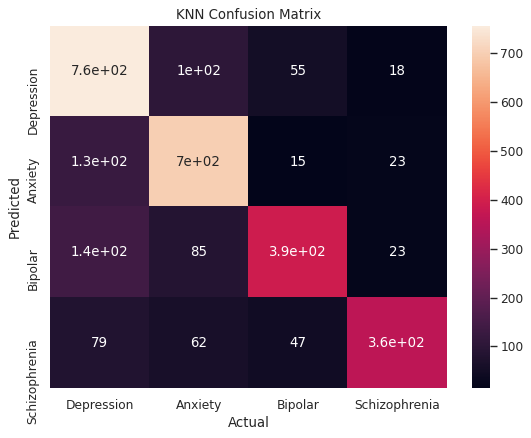

time: 3min 54s (started: 2021-11-27 20:08:55 +00:00)


In [99]:
#Run example with one trian test split for confusion matrix

knn = KNeighborsClassifier(n_neighbors = 27)
knn_model = knn.fit(features_train, labels_train)

knn_predictions = knn_model.predict(features_test)

#Print model evaluation report
print ("KNN Classification Report")
print(classification_report(labels_test, knn_predictions))

#Confusion Matrix
figure(figsize=(8, 6), dpi=80)
cfmatrix = confusion_matrix(labels_test, knn_predictions)
sns.heatmap(cfmatrix, annot=True, xticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'], yticklabels=['Depression','Anxiety','Bipolar','Schizophrenia'])
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('KNN Confusion Matrix')

#Add values for model comparison
model_evaluation.update({'KNN' : [accuracy_score(labels_train, knn.predict(features_train)),accuracy_score(labels_test, knn_predictions)]})

## Model Comparison

By comparing accuracy scores across all models, we can assess which model performs the best for our purpose

In [100]:
model_df = pd.DataFrame.from_dict(model_evaluation.items())
model_df = model_df.rename(columns={0:'Model', 1:'Testing_Accuracy'})
model_df[['Training Accuracy','Testing Accuracy']] = pd.DataFrame(model_df.Testing_Accuracy.tolist(), index = model_df.index)

model_df = model_df[['Model','Training Accuracy','Testing Accuracy']]

model_df

,Model,Training Accuracy,Testing Accuracy
0,Naive Bayes,0.792162,0.775620
1,Logistic Regression,0.866187,0.837910
2,KNN,0.762184,0.739786


time: 14.7 ms (started: 2021-11-27 20:29:20 +00:00)


It appears that none of the models are overfit to the training data, as model performance is similar on both training and testing data. From the data, we can see that the Logistic Regression model performed the best with a prediction accuracy of ~84%.

## Logistic Regression

## Twitter Analysis

Using the classification model trained on Reddit forum conversations related to mental health, we can categorize Tweets into various mental health indications. The key value proposition of using Twitter data is that it also includes user information, including the location of the author. We can use this information to assess changes in mental health conversation volumes regionally, and in response to COVID-19 changes in various provinces.

Based on the model performance noted above, we will use the Logistic Regression model to classify tweets.

### Read & Format Data

In [139]:
twitter_df = pd.read_csv('twitter_corpus.csv', encoding = 'unicode_escape')
twitter_df = pd.DataFrame(twitter_df)

#Drop N/A values, and include only posts which have an identified geographic region

twitter_df = twitter_df[twitter_df['Snippet'].notna()]
twitter_df = twitter_df[twitter_df['Region'].notna()]
twitter_df = twitter_df.drop_duplicates(subset=['Snippet'])

#Text processing
#Data Cleaning - Snippet

print(twitter_df['Snippet'][0])


#Remove author names from the posts, which are any terms starting with '@'
stripped_authors = []
for i in twitter_df.index:
    stripped_authors.append(' '.join(w for w in twitter_df['Snippet'][i].split(' ') if not w.startswith('@')))
    
twitter_df['Snippet'] = stripped_authors
print(twitter_df['Snippet'][0])

#Remove all non-alphanumeric characters to clean up text and remove symbols, emojis, etc.
stripped_strings = []
for i in twitter_df.index:
    stripped_strings.append(re.sub(r'[^A-Za-z0-9 ]+', '', twitter_df['Snippet'][i]))
        
twitter_df['Snippet'] = stripped_strings
print(twitter_df['Snippet'][0])

#Twitter posts are stored as a list of string values. To process each string value in the list, iterate the function over each string item in the list. Then return formatted lists
# to string format
lowercase_posts = []
for i in twitter_df.index:
    lowercase_posts.append(twitter_df['Snippet'][i].lower())

twitter_df['Snippet'] = lowercase_posts
print(twitter_df['Snippet'][0])

#Remove punctuation from posts
strip_punctuation = []
for i in twitter_df.index:
    strip_punctuation.append(twitter_df['Snippet'][i].translate(str.maketrans('','',string.punctuation)))

twitter_df['Snippet'] = strip_punctuation
print(twitter_df['Snippet'][0])

#Tokenize each string input to generate list of lists containing string values
tokenized_posts = []
for i in twitter_df.index:
    tokenized_posts.append(word_tokenize(twitter_df['Snippet'][i]))

twitter_df['Snippet'] = tokenized_posts
print(twitter_df['Snippet'][0])

#Remove stopwords

filtered_posts = []
for i in twitter_df.index:
    filtered_posts.append([w for w in twitter_df['Snippet'][i] if w not in stopwords])
    
twitter_df['Snippet'] = filtered_posts
print(twitter_df['Snippet'][0])

#Convert processed text from list to string

new_strings = []
for i in twitter_df.index:
    new_strings.append(' '.join(twitter_df['Snippet'][i]))

twitter_df['Snippet'] = new_strings
print(twitter_df['Snippet'][0])

#Lemmatize posts
wn = WordNetLemmatizer()
lemmatized_posts = []

for i in twitter_df.index:
    lemmatized_content = []
    post = twitter_df['Snippet'][i]
    post_words = post.split(" ")
    for word in post_words:
        lemmatized_content.append(wn.lemmatize(word, pos='v'))
    lemmatized_post = " ".join(lemmatized_content)
    lemmatized_posts.append(lemmatized_post)

twitter_df['Snippet'] = lemmatized_posts
print(twitter_df['Snippet'][0])

#twitter_df

@tarastrong Also, some could say thatâs schizophrenia ð
Also, some could say thatâs schizophrenia ð
Also some could say thats schizophrenia 
also some could say thats schizophrenia 
also some could say thats schizophrenia 
['also', 'some', 'could', 'say', 'thats', 'schizophrenia']
['also', 'could', 'say', 'thats', 'schizophrenia']
also could say thats schizophrenia
also could say thats schizophrenia
time: 3.39 s (started: 2021-11-27 21:23:03 +00:00)


In [140]:
#Transform 
np.set_printoptions(threshold=1000)
tweets = twitter_df['Snippet']

#Convert Tweets to vectors
tweet_vectors = tfidf.transform(tweets).toarray()


#Run predictive model
tweet_predictions = lgreg_model.predict(tweet_vectors)
tweet_predictions = tweet_predictions.tolist()


#Generate dataframe showing tweet and its predicted mental health indication

tweet_classifications = {'Snippet': tweets, 'topic_code' : tweet_predictions}

tweet_df = pd.DataFrame(tweet_classifications)

categories = []
for i in tweet_df.index:
    if tweet_df['topic_code'][i] == 0:
        categories.append('Depression')
    elif tweet_df['topic_code'][i] == 1:
        categories.append('Anxiety')
    elif tweet_df['topic_code'][i] == 2:
        categories.append('Bipolar')
    elif tweet_df['topic_code'][i] == 3:
        categories.append('Schizophrenia')

tweet_df['Categories'] = categories

tweet_df

,Snippet,topic_code,Categories
0,also could say thats schizophrenia,3,Schizophrenia
1,man go doctor say hes depress say life seem ha...,0,Depression
2,whenever someone adhd andor autism something s...,0,Depression
3,anxiety worst,1,Anxiety
4,xicheng stans stop depress every au ideablurb ...,0,Depression
...,...,...,...
7580,twitter edit need ugh tire tell often like muc...,0,Depression
7582,depression also allow,0,Depression
7583,depression acute try resign kpmgschief mental ...,0,Depression
7584,holy shit everyone today bff horrible days act...,0,Depression


time: 631 ms (started: 2021-11-27 21:27:11 +00:00)


In [147]:
feature_scores = dict(zip(tfidf.get_feature_names(), tweet_vectors[0])) #Can use this function to view the TF-IDF scores of any given post for x_train by changing features_train index
example = sorted(feature_scores.items(), key = lambda x: x[1], reverse=True)
example[:25]

[('thats', 0.5306691058074672),
 ('could', 0.46640408481008855),
 ('also', 0.43297913139928107),
 ('say', 0.4162143123746666),
 ('schizophrenia', 0.3743691330240441),
 ('10', 0.0),
 ('able', 0.0),
 ('absolutely', 0.0),
 ('accept', 0.0),
 ('act', 0.0),
 ('actually', 0.0),
 ('adhd', 0.0),
 ('advice', 0.0),
 ('affect', 0.0),
 ('afraid', 0.0),
 ('age', 0.0),
 ('ago', 0.0),
 ('almost', 0.0),
 ('alone', 0.0),
 ('already', 0.0),
 ('always', 0.0),
 ('another', 0.0),
 ('answer', 0.0),
 ('antidepressants', 0.0),
 ('anxiety', 0.0)]

time: 6.71 ms (started: 2021-11-27 21:33:49 +00:00)


In [148]:
#Merge location data from twitter_df to add additional context for analysis
classified_tweets = pd.merge(tweet_df, twitter_df, on = 'Snippet', how ='inner')
classified_tweets = classified_tweets[['Date','Snippet','Categories','Country','Region']]
classified_tweets = classified_tweets.replace('QuÃ©bec', 'Quebec')  #Fix formatting
classified_tweets

,Date,Snippet,Categories,Country,Region
0,9/17/2021,also could say thats schizophrenia,Schizophrenia,Canada,Ontario
1,8/18/2021,man go doctor say hes depress say life seem ha...,Depression,Canada,Ontario
2,8/10/2020,whenever someone adhd andor autism something s...,Depression,Canada,Alberta
3,5/14/2021,anxiety worst,Anxiety,Canada,Ontario
4,1/14/2020,xicheng stans stop depress every au ideablurb ...,Depression,Canada,Ontario
...,...,...,...,...,...
7280,3/11/2020,twitter edit need ugh tire tell often like muc...,Depression,Canada,British Columbia
7281,2/10/2021,depression also allow,Depression,Canada,Ontario
7282,5/25/2021,depression acute try resign kpmgschief mental ...,Depression,Canada,Ontario
7283,10/1/2020,holy shit everyone today bff horrible days act...,Depression,Canada,Ontario


time: 31.8 ms (started: 2021-11-27 21:37:33 +00:00)


### Twitter Analysis

First, we can look at the distribution of posts among mental health categories to see which mental health indications have been most prevalent in social media discussions over the course of the pandemic. From the distributon we can see that posts which are indicative of Depression are the most prevalant in social media, followed by Anxiety, Schizophrenia and Bipolar disorder.

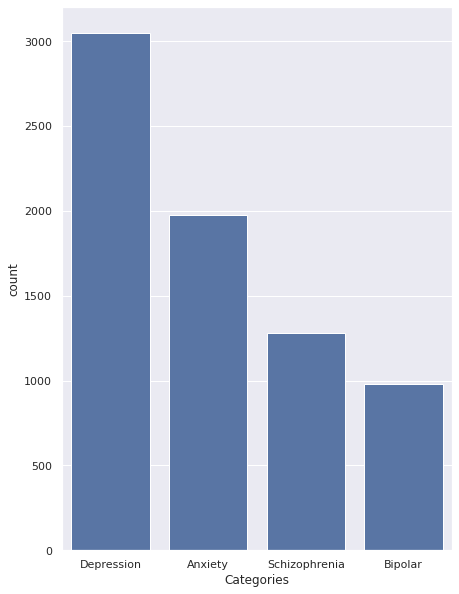

Schizophrenia  :  17.543%
Depression  :  41.867%
Anxiety  :  27.138%
Bipolar  :  13.452%
time: 175 ms (started: 2021-11-27 21:27:19 +00:00)


In [142]:
sns.set_color_codes('pastel')
sns.set(style='darkgrid')
sns.set(rc={'figure.figsize':(7,10)})
sns.countplot(x='Categories', data=classified_tweets, order = classified_tweets['Categories'].value_counts().index, color='b')
plt.show()

categories = []
percentages = []
for i in Counter(classified_tweets['Categories']):
    categories.append(i) 
    percentages.append(str(round(len(classified_tweets[classified_tweets['Categories']==i])/len(classified_tweets),5)*100) + '%')

zipped_values = zip(categories, percentages)
categories_dist = dict(zipped_values)

for k, v in categories_dist.items():
    print(k, ' : ', v)


Next, we look at the distribution of tweets by region to understand which areas are most highly represented in our dataset. In this case we can see Ontario makes up the vast majority (~61%) of posts

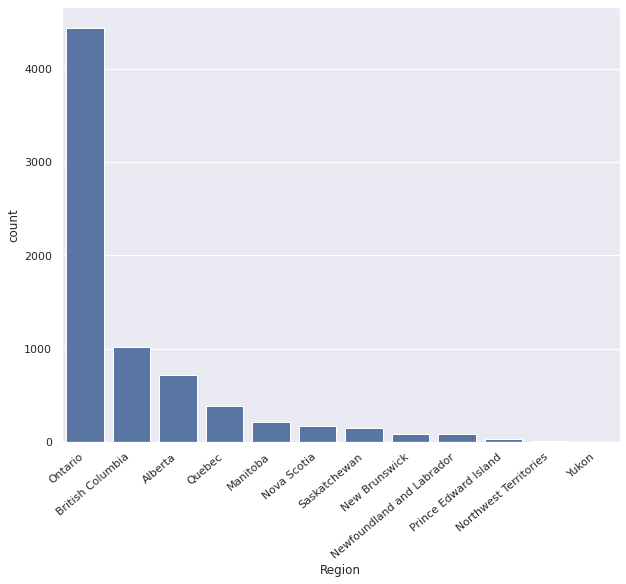

Ontario  :  60.988%
Alberta  :  9.774%
Saskatchewan  :  2.086%
British Columbia  :  13.919%
Quebec  :  5.189%
Newfoundland and Labrador  :  1.098%
Northwest Territories  :  0.055%
Nova Scotia  :  2.375%
Manitoba  :  2.938%
Prince Edward Island  :  0.426%
New Brunswick  :  1.126%
Yukon  :  0.027%
time: 265 ms (started: 2021-11-27 21:27:22 +00:00)


In [143]:
#View regional breakdown 
provinces = []
percentages = []
for i in Counter(classified_tweets['Region']):
    provinces.append(i) 
    percentages.append(str(round(len(classified_tweets[classified_tweets['Region']==i])/len(classified_tweets),5)*100) + '%')

zipped_values = zip(provinces, percentages)
regional_dist = dict(zipped_values)

#Plot counts
sns.set_color_codes('pastel')
sns.set(style='darkgrid')
plt.figure(figsize=(10,8))
ax = sns.countplot(x='Region', data=classified_tweets, order = classified_tweets['Region'].value_counts().index, color='b', label='# of Tweets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.show()

#Show percentage breakdown
for k, v in regional_dist.items():
    print(k, ' : ', v)


To understand the mental health needs within various regions, we can breakdown social media posts within each region by their associated mental health indication as predicted by our logistic regression model. This gives us an idea of what the most pressing mental health issues are across Canada.

Below we can see that among the regions that are most highly represented in our data (Ontario, British Columbia, Alberta, Quebec), Depression and Anxiety come through as the two main areas of concern. Among provinces with less data, the distribution across indications becomes more even. In general, Depression and Anxiety remain the highest areas of concern for most smaller provinces. However, an interesting pattern emerges in Saskatchewan and New Brunswick, which were the only two provinces where schizophrenia appears as the most prominent mental health concern.

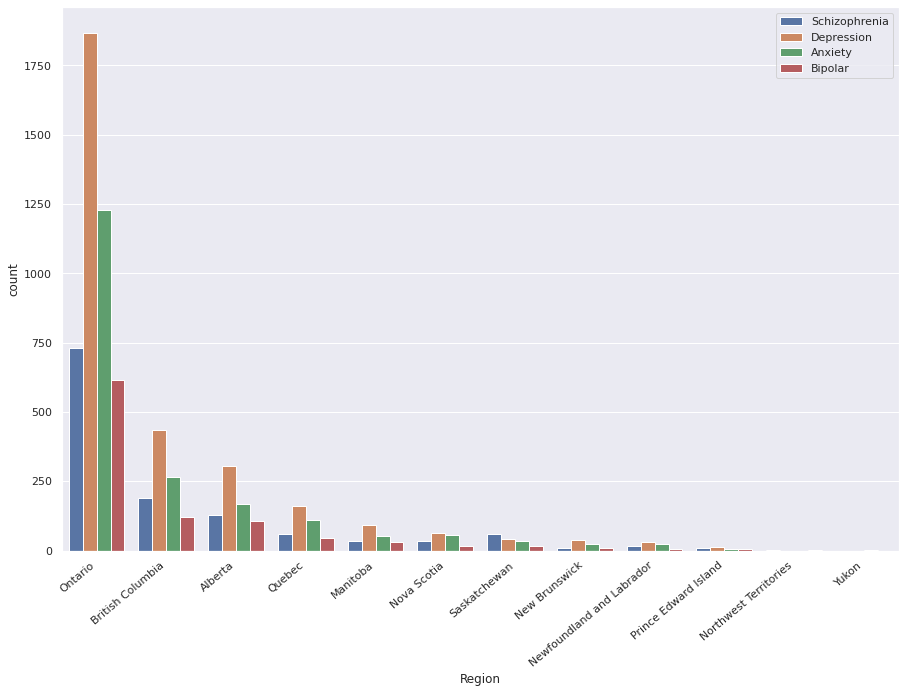

time: 425 ms (started: 2021-11-27 21:27:26 +00:00)


In [144]:
sns.set_color_codes('pastel')
sns.set(style='darkgrid')
plt.figure(figsize=(15,10))
ax = sns.countplot(x='Region', data=classified_tweets, order = classified_tweets['Region'].value_counts().index, hue='Categories')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.legend(loc='upper right')
plt.show()

In [123]:
#Breakdown region by indication
total = classified_tweets.groupby('Region')['Snippet'].count()
depression = classified_tweets[classified_tweets.Categories=='Depression'].groupby('Region')['Snippet'].count()
anxiety = classified_tweets[classified_tweets.Categories=='Anxiety'].groupby('Region')['Snippet'].count()
bipolar = classified_tweets[classified_tweets.Categories=='Bipolar'].groupby('Region')['Snippet'].count()
schizophrenia = classified_tweets[classified_tweets.Categories=='Schizophrenia'].groupby('Region')['Snippet'].count()



time: 18.5 ms (started: 2021-11-27 20:45:48 +00:00)


### Future Directions: Time Series Analysis

A future direction for this analysis would be to plot volume within various conversations over time and correlate changes in volume to COVID-19 related events such as lockdowns,etc. Note, this is beyond the scope of this project.

In [43]:
#Generate separate dataframes for each indication
depression_df = reddit_df[reddit_df['Subreddit'] == 'r/Depression']
anxiety_df = reddit_df[reddit_df['Subreddit'] == 'r/Anxiety']
schizophrenia_df = reddit_df[reddit_df['Subreddit'] == 'r/Schizophrenia']
bipolar_df = reddit_df[reddit_df['Subreddit'] == 'r/Bipolar']


#Define function for generating post volume counts by month for each indication

def postvolume(x):
        num_posts = x.groupby(pd.Grouper(key='Date', freq='M')).count()
        num_posts = pd.DataFrame(num_posts)
        num_posts = num_posts.drop(['Query Id','Query Name','Subreddit','Title','Snippet'],axis=1)
        num_posts = num_posts.rename(columns={'content':'Posts'})
        return num_posts
    


#Run function on each indication to generate post volumes over time
depression_volume = postvolume(depression_df)
anxiety_volume = postvolume(anxiety_df)
schizophrenia_volume = postvolume(schizophrenia_df)
bipolar_volume = postvolume(bipolar_df)
    

    
#Plot activity over time for each subreddit

#from matplotlib.pyplot import figure
#figure(figsize=(10,8), dpi=80)
#plt.plot(depression_volume, label='r/Depression')
#plt.plot(anxiety_volume, label = 'r/Anxiety')
#plt.plot(schizophrenia_volume, label = 'r/schizophrenia')
#plt.plot(bipolar_volume, label = 'r/bipolar')

time: 54.5 ms (started: 2021-11-24 23:28:01 +00:00)
